In [1]:
import sys
import os
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
sys.path.insert(0, '../')
from analysis.analysis_utils import *

/home/leehojoon/.pyenv/versions/3.9.5/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Collect Results

In [63]:
eval_df = read_and_concatenate_eval_df(directory_path='../results/baseline')
print(eval_df['exp_name'].unique())
eval_df

['simbaV2_utd2' 'tdmpc2' 'mrq' 'bro_utd10' 'simba_utd2' 'bro_utd2'
 'mad_td_utd8' 'simbaV2_utd8' 'CrossQ']


,exp_name,env_name,seed,metric,env_step,value
0,simbaV2_utd2,h1-pole-v0,9000,avg_return,0.0,34.269159
1,simbaV2_utd2,h1-pole-v0,9000,avg_return,100000.0,303.279434
2,simbaV2_utd2,h1-pole-v0,9000,avg_return,200000.0,590.137001
3,simbaV2_utd2,h1-pole-v0,9000,avg_return,300000.0,657.775993
4,simbaV2_utd2,h1-pole-v0,9000,avg_return,400000.0,711.609390
...,...,...,...,...,...,...
376001,CrossQ,Humanoid-v4,0,avg_return,992000.0,10703.832031
376002,CrossQ,Humanoid-v4,0,avg_return,994000.0,10753.225586
376003,CrossQ,Humanoid-v4,0,avg_return,996000.0,10829.421875
376004,CrossQ,Humanoid-v4,0,avg_return,998000.0,10807.573242


In [64]:
from rliable import library as rly
from rliable import metrics as rly_metrics
from rliable import plot_utils as rly_plot_utils

aggregate_func = lambda x: np.array([
  rly_metrics.aggregate_iqm(x),
  rly_metrics.aggregate_median(x),
  rly_metrics.aggregate_mean(x),
  rly_metrics.aggregate_optimality_gap(x)])

In [65]:
from scale_rl.envs.mujoco import MUJOCO_ALL, MUJOCO_RANDOM_SCORE, MUJOCO_TD3_SCORE
from scale_rl.envs.dmc import DMC_EASY_MEDIUM, DMC_HARD
from scale_rl.envs.humanoid_bench import HB_LOCOMOTION_NOHAND, HB_RANDOM_SCORE, HB_SUCCESS_SCORE, HB_LOCOMOTION_NOHAND_MINI
from scale_rl.envs.myosuite import MYOSUITE_TASKS

In [66]:
def replace_hypen_to_underbar(env_name_list):
    for idx in range(len(env_name_list)):
        env_name_list[idx] = env_name_list[idx].replace('-', '_')
    return env_name_list

def replace_hyphen_in_dict_keys(old_dict):
    new_dict = {}
    for k, v in old_dict.items():
        new_key = k.replace('-', '_')  # <--- direct string replace
        new_dict[new_key] = v
    return new_dict

MUJOCO_ALL = replace_hypen_to_underbar(MUJOCO_ALL)
DMC_EM = replace_hypen_to_underbar(DMC_EASY_MEDIUM)
DMC_HARD = replace_hypen_to_underbar(DMC_HARD)
MYOSUITE_TASKS = replace_hypen_to_underbar(MYOSUITE_TASKS)
HB_LOCOMOTION_NOHAND = replace_hypen_to_underbar(HB_LOCOMOTION_NOHAND)
HB_LOCOMOTION_NOHAND_MINI = replace_hypen_to_underbar(HB_LOCOMOTION_NOHAND_MINI)

MUJOCO_RANDOM_SCORE = replace_hyphen_in_dict_keys(MUJOCO_RANDOM_SCORE)
MUJOCO_TD3_SCORE = replace_hyphen_in_dict_keys(MUJOCO_TD3_SCORE)
HB_RANDOM_SCORE = replace_hyphen_in_dict_keys(HB_RANDOM_SCORE)
HB_SUCCESS_SCORE = replace_hyphen_in_dict_keys(HB_SUCCESS_SCORE)

eval_df['env_name'] = eval_df['env_name'].str.replace('-', '_')
eval_df

,exp_name,env_name,seed,metric,env_step,value
0,simbaV2_utd2,h1_pole_v0,9000,avg_return,0.0,34.269159
1,simbaV2_utd2,h1_pole_v0,9000,avg_return,100000.0,303.279434
2,simbaV2_utd2,h1_pole_v0,9000,avg_return,200000.0,590.137001
3,simbaV2_utd2,h1_pole_v0,9000,avg_return,300000.0,657.775993
4,simbaV2_utd2,h1_pole_v0,9000,avg_return,400000.0,711.609390
...,...,...,...,...,...,...
376001,CrossQ,Humanoid_v4,0,avg_return,992000.0,10703.832031
376002,CrossQ,Humanoid_v4,0,avg_return,994000.0,10753.225586
376003,CrossQ,Humanoid_v4,0,avg_return,996000.0,10829.421875
376004,CrossQ,Humanoid_v4,0,avg_return,998000.0,10807.573242


In [67]:
cur_exp_names = eval_df['exp_name'].unique()
cur_exp_names

array(['simbaV2_utd2', 'tdmpc2', 'mrq', 'bro_utd10', 'simba_utd2',
       'bro_utd2', 'mad_td_utd8', 'simbaV2_utd8', 'CrossQ'], dtype=object)

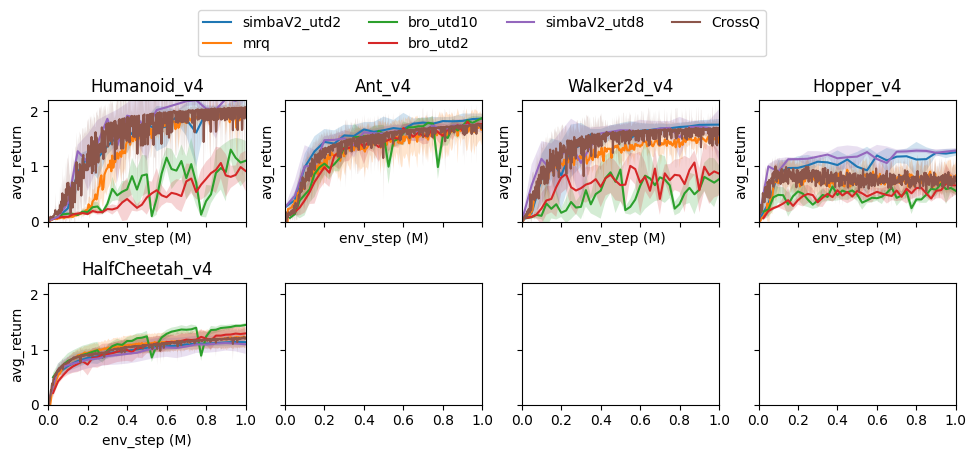

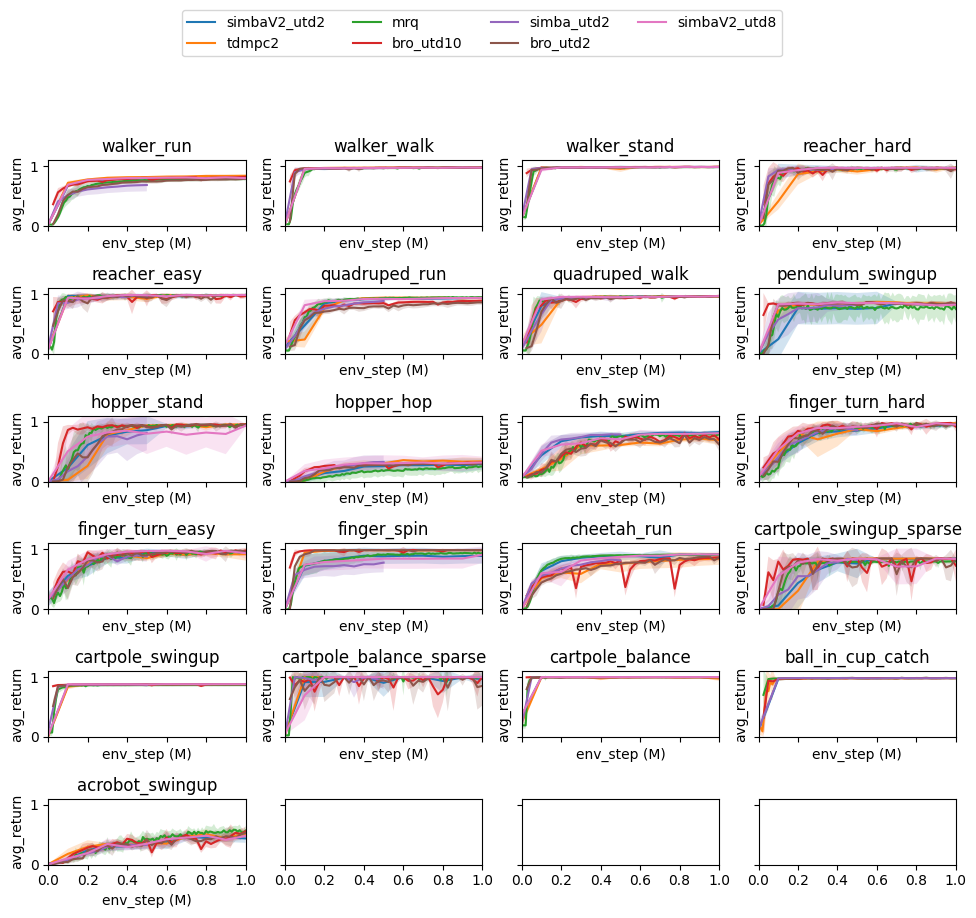

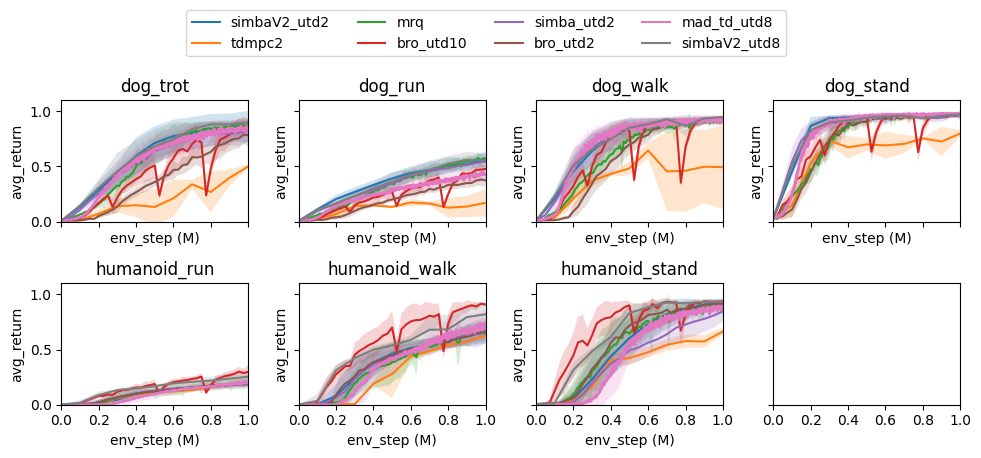

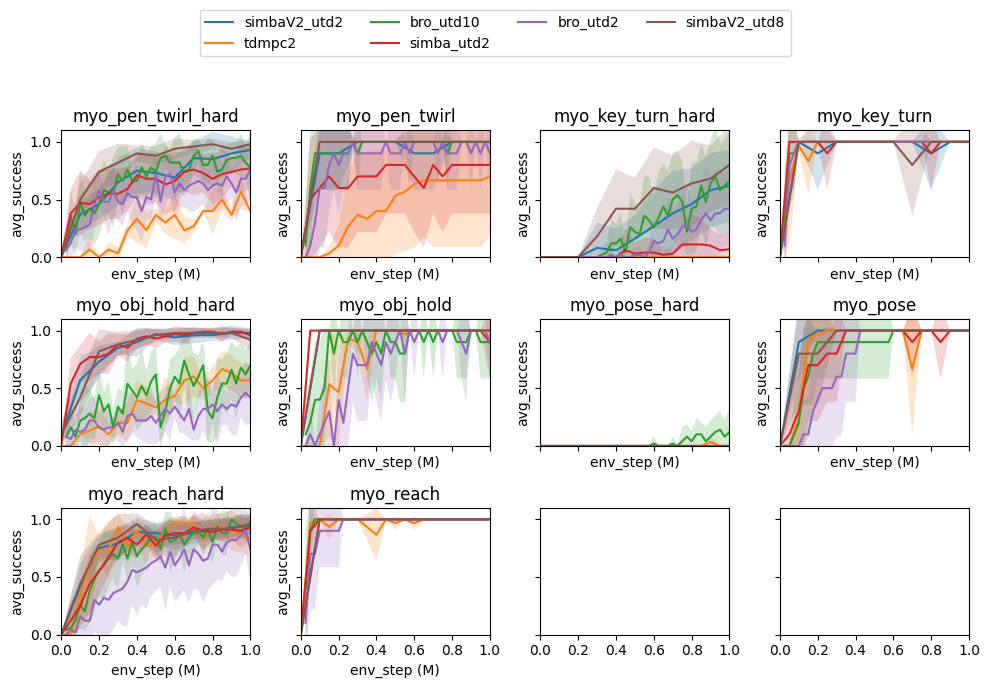

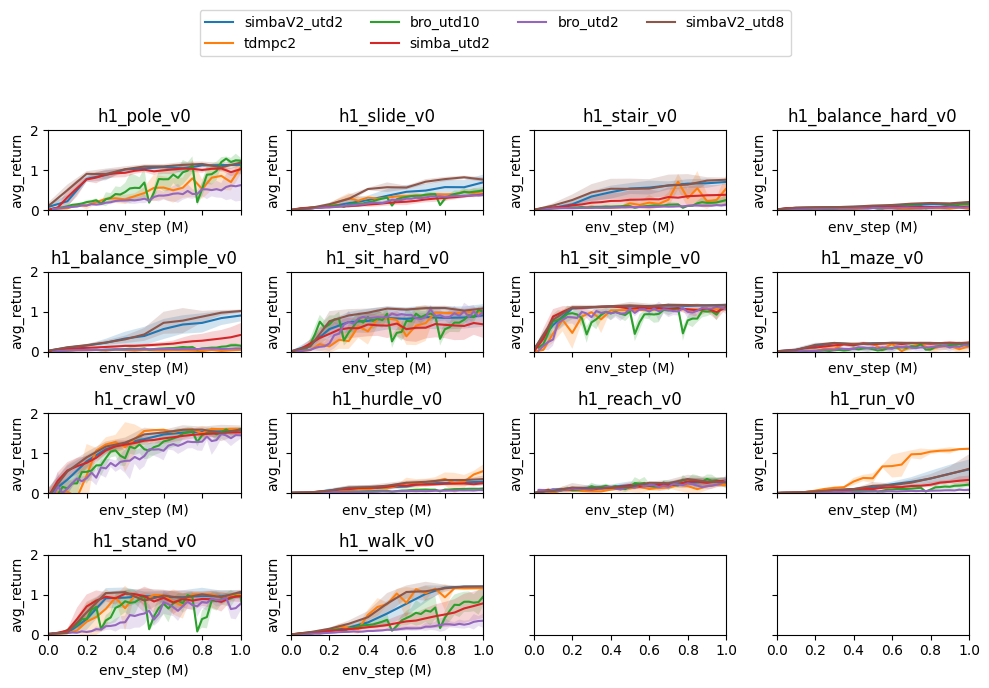

In [68]:
domain_metric_mats = defaultdict(dict)
all_metric_mats = defaultdict(list)

for env_type in ["MUJOCO", "DMC_EM", "DMC_HARD", "MYOSUITE", "HBench"]:
    if env_type == "MUJOCO":
        env_list = MUJOCO_ALL
        env_step = 1e6
        metric_type = "avg_return"
        plot_height = 4
        y_lim_max = 2.2

    elif env_type == "DMC_EM":
        env_list = DMC_EM
        env_step = 1e6
        metric_type = "avg_return"
        plot_height = 8
        y_lim_max = 1.1

    elif env_type == "DMC_HARD":
        env_list = DMC_HARD
        env_step = 1e6
        metric_type = "avg_return"
        plot_height = 4
        y_lim_max = 1.1

    elif env_type == "MYOSUITE":
        env_list = MYOSUITE_TASKS
        env_step = 1e6
        metric_type = "avg_success"
        plot_height = 6
        y_lim_max = 1.1

    elif env_type == "HBench":
        env_list = HB_LOCOMOTION_NOHAND
        env_step = 1e6
        metric_type = "avg_return"
        plot_height = 6
        y_lim_max = 2.0

    # Filter eval_df for current environment set and experiments
    _eval_df = eval_df[eval_df["env_name"].isin(env_list)]
    _eval_df = _eval_df[_eval_df["exp_name"].isin(cur_exp_names)]

    # Additional environment-specific normalization, etc.
    if env_type == "MUJOCO":
        _eval_df = normalize_score_with_random_and_base_score(
            _eval_df,
            MUJOCO_RANDOM_SCORE,
            MUJOCO_TD3_SCORE,
        )
    elif env_type in ["DMC_EM", "DMC_HARD"]:
        _eval_df.loc[:, "value"] /= 1000.0
    elif env_type == "HBench":
        _eval_df = normalize_score_with_random_and_base_score(
            _eval_df,
            HB_RANDOM_SCORE,
            HB_SUCCESS_SCORE,
        )

    # (Optional) plot metric history for each environment in this env_type
    plot_metric_history_per_env(
        _eval_df,
        num_plots_per_row=4,
        metric=metric_type,
        x_lim_max=env_step,
        y_lim_max=y_lim_max,
        plot_width=10,
        plot_height=plot_height,
        y_label=metric_type,
    )

    # Generate metric matrix dictionary for this env_type
    _metric_matrix_dict = generate_metric_matrix_dict(
        _eval_df, env_step=env_step, metric_type=metric_type
    )

    # Collect these matrices into all_metric_mats
    for exp_name, mat in _metric_matrix_dict.items():
        domain_metric_mats[env_type][exp_name] = mat
        all_metric_mats[exp_name].append(mat)


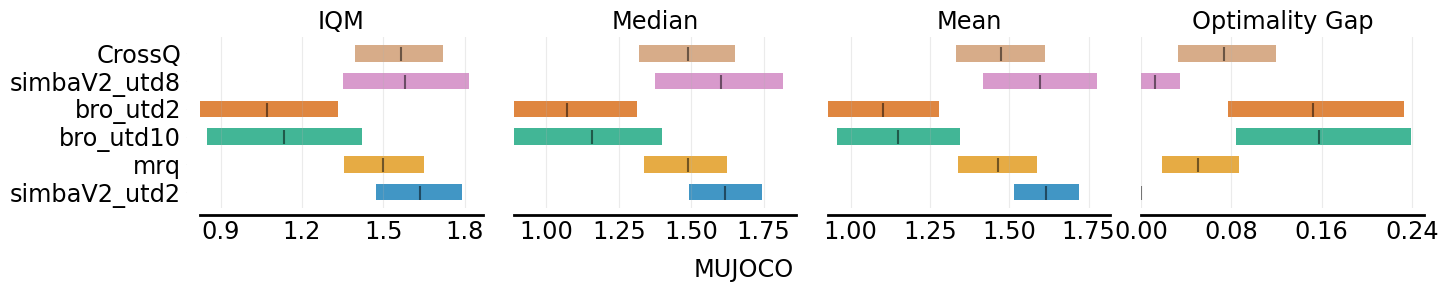

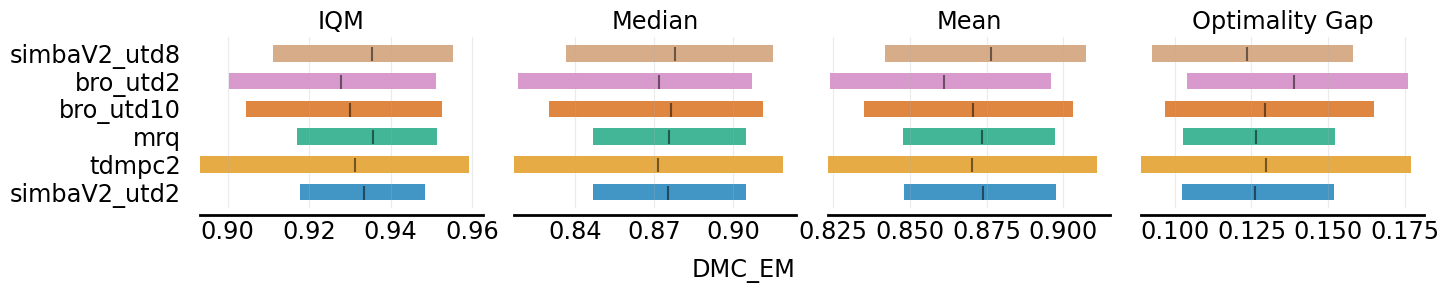

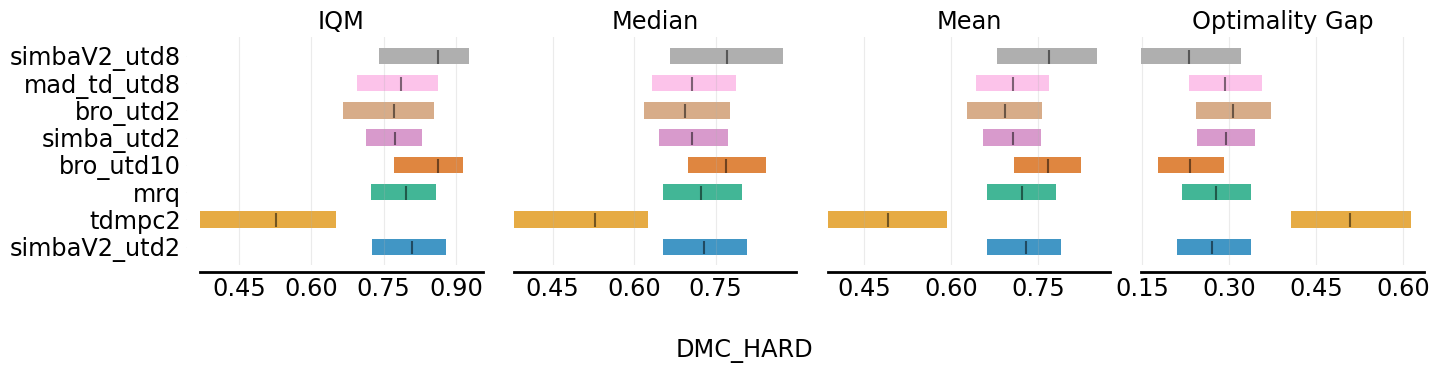

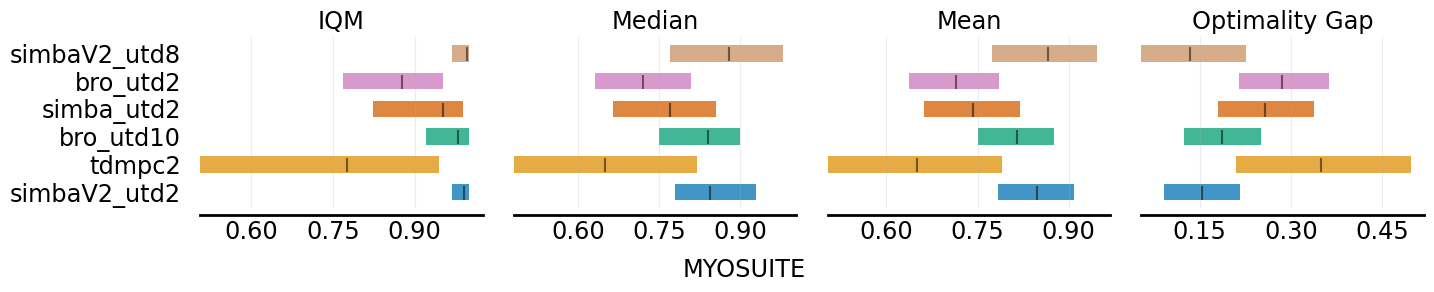

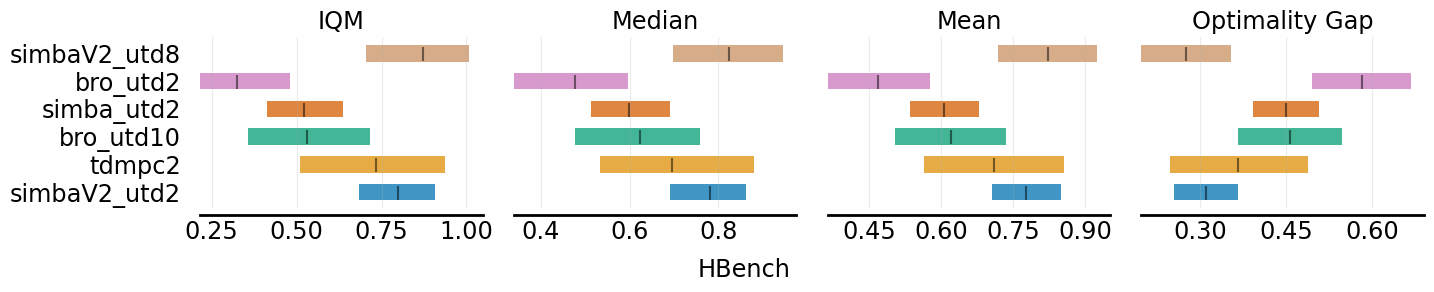

In [75]:
domain_aggregate_scores = {}
domain_aggregate_score_cis = {}

for env_type, exp_dict in domain_metric_mats.items():
    # exp_dict is {exp_name: matrix(# tasks_in_domain, # seeds)}
    aggregate_scores = {}
    aggregate_score_cis= {}

    for exp_name, mat in exp_dict.items():
        # If needed, you could do seed slicing or other checks here,
        # in case you must unify number of seeds across tasks in a domain.
        # Typically, generate_metric_matrix_dict() has already done that.

        # Build a single dict for robust-liness
        single_exp_dict = {exp_name: mat}

        # For example, rly.get_interval_estimates(...) with your chosen aggregator
        single_scores, single_cis = rly.get_interval_estimates(
            single_exp_dict,
            aggregate_func,  # e.g., rly.aggregate_iqm, or your custom aggregator
            reps=10000,
        )
        aggregate_scores[exp_name] = single_scores[exp_name]
        aggregate_score_cis[exp_name] = single_cis[exp_name]

    fig, axes = rly_plot_utils.plot_interval_estimates(
        aggregate_scores, aggregate_score_cis,
        metric_names=['IQM', 'Median', 'Mean', 'Optimality Gap'],
        algorithms=list(exp_dict.keys()),
        xlabel_y_coordinate=-0.2,
        xlabel=env_type,
    )

In [76]:
metric_matrix_dict = {}
for exp_name, mats_list in all_metric_mats.items():
    # Find the minimum number of seeds among all matrices in mats_list
    min_num_seeds = min(mat.shape[1] for mat in mats_list)
    
    # Slice each matrix to keep only the first min_num_seeds columns
    mats_sliced = [mat[:, :min_num_seeds] for mat in mats_list]
    
    # Concatenate vertically
    # Resulting shape: [sum_of_envs_across_env_types, min_num_seeds]
    metric_matrix_dict[exp_name] = np.concatenate(mats_sliced, axis=0)

aggregate_scores = {}
aggregate_score_cis= {}

# Loop over each experiment (key) separately
for exp_name, mat in metric_matrix_dict.items():
    # We pass a small dict with just this experiment's data
    single_exp_dict = {exp_name: mat}
    
    # Compute interval estimates for only this experiment
    single_scores, single_cis = rly.get_interval_estimates(
        single_exp_dict,
        aggregate_func,  # e.g. rly.aggregate_iqm or custom
        reps=10000
    )
    
    # Store the result back into all_agg_scores, all_agg_cis
    # single_scores[exp_name] is something like [IQM, Median, Mean, Optimality Gap]
    aggregate_scores[exp_name] = single_scores[exp_name]
    aggregate_score_cis[exp_name] = single_cis[exp_name]

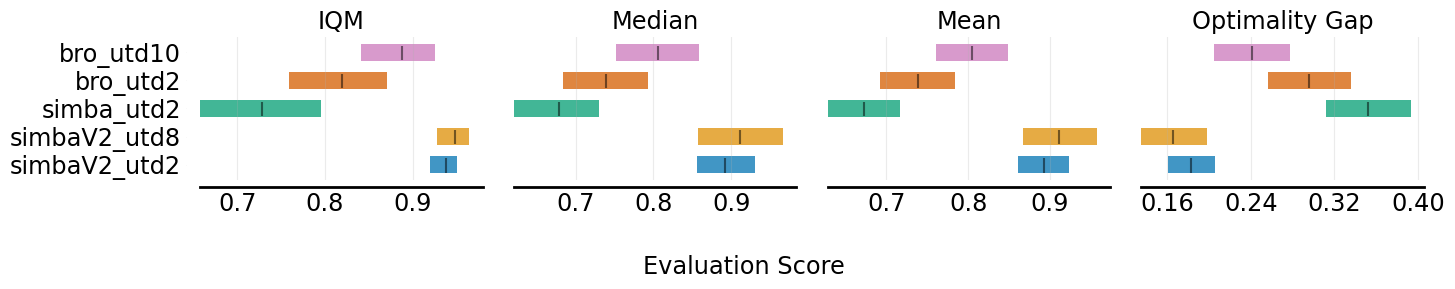

In [77]:
fig, axes = rly_plot_utils.plot_interval_estimates(
    aggregate_scores, aggregate_score_cis,
    metric_names=['IQM', 'Median', 'Mean', 'Optimality Gap'],
    algorithms=['simbaV2_utd2','simbaV2_utd8', 'simba_utd2', 'bro_utd2', 'bro_utd10'],
    xlabel_y_coordinate=-0.4,
    xlabel='Evaluation Score',
)